# Imports

In [1]:
import sys
import os
import math

import time
import datetime as dt

import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from itertools import combinations, combinations_with_replacement

import optuna
import pickle

# Default device and type

In [2]:
# Check to see if gpu is available. If it is, use it else use the cpu
if torch.cuda.is_available():
  device = torch.device("cuda:0") 
  print('Using ', device, ': ', torch.cuda.get_device_name())  
  print(torch.cuda.get_device_properties(torch.cuda))
  ! nvidia-smi
else:
  device = torch.device('cpu')
  print('No GPU found, using cpu')

torch.set_default_dtype(torch.float32)#64)
torch.set_default_device(device)

Using  cuda:0 :  NVIDIA GeForce RTX 3050 Laptop GPU
_CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=16)
Tue Mar 26 13:02:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.65                 Driver Version: 546.65       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P0               9W /  65W |      0MiB /  4096MiB |

# Enable model differentiation by X

In [3]:
class diff_model_enable:
  def __init__(self, model, X):
    self.model = model
    self.X = X
  
  def __enter__(self):
    self.X.requires_grad = True
  
  def __exit__(self, exc_type, exc_val, exc_tb):
    self.X.requires_grad = False

In [4]:
def diff2(f, X):
  grads = torch.autograd.grad(
    outputs=f, inputs=X, grad_outputs=torch.ones_like(f),
    create_graph=True
  )[0]
  grad_grad = []
  for i in range(X.shape[1]):
    df = grads[:,i]
    df2 = torch.autograd.grad(
      outputs=df, inputs=X, grad_outputs=torch.ones_like(df),
      create_graph=True
    )[0][:,i]
    grad_grad.append(df2)
  return torch.stack(grad_grad, dim=1)

# Metropolis sampler

In [5]:
class MetropolisSampler():
  def __init__(self, dim1, dim2, epsilon=1, R=1.5):
    self.epsilon = epsilon
    self.R = R
    self.dim1, self.dim2 = dim1, dim2
    self.sample = self.initialSample()

  def initialSample(self) -> torch.Tensor:
    return 2 * self.R * (
      torch.rand(
        (
          self.dim1, self.dim2
        )
      ) - 0.5
    )

  def updateSampleBasOnDistrDens(self, __distributionDensity):
    newSample = self.sample + self.epsilon * (
      2 * torch.rand_like(
        self.sample,
      ) - 1
    )
    critVal = __distributionDensity(newSample) / __distributionDensity(self.sample)
    doesPointMove = (torch.rand(len(self.sample)) <= critVal)
    newSample = (
      torch.mul(doesPointMove.int(), newSample.t()).t()
      + torch.mul((1 - doesPointMove.int()), self.sample.t()).t()
    )
    self.sample = newSample
    acc_rate = torch.sum(doesPointMove.int())/len(doesPointMove)
    if acc_rate > 0.5:
      self.epsilon *= 1.001
    else:
      self.epsilon *= 0.999

  def updateAndGetSample(self, __distributionDensity):
    # for i in range(10):
    self.updateSampleBasOnDistrDens(__distributionDensity)
    return self.sample

# Trial function

In [6]:
class TrialFunction(nn.Module):
  def __init__(self, dim_coord, num_states, potential, name,
               num_hidden_layers=3, num_hidden_neurons=60,
               init_mean_weights=0.0, init_std_weights=math.sqrt(0.1),
               activ_fnc=nn.Tanh()):
    super(TrialFunction, self).__init__()
    
    self.dim_coord = dim_coord
    self.num_states = num_states
    self.potential = potential

    self.name = name
    
    self.num_hidden_layers = num_hidden_layers
    self.num_hidden_neurons = num_hidden_neurons
    self.activ_fnc = activ_fnc
    # Layers
    self.layers = nn.Sequential()
    self.layers.append(nn.Linear(dim_coord, num_hidden_neurons))
    self.layers.append(activ_fnc)
    for layer in range(num_hidden_layers-1):
      self.layers.append(nn.Linear(num_hidden_neurons, num_hidden_neurons))
      self.layers.append(activ_fnc)
    # Gaussian weights
    self.gaussian_weights = nn.Linear(dim_coord, num_hidden_neurons, bias=False)
    # Out layer
    self.out_layer = nn.ModuleList(
      [nn.Linear(num_hidden_neurons, 1, bias=False) for state in range(num_states)]
    )
    # Initialise weigths
    self.init_weights(init_mean_weights, init_std_weights)

  def init_weights(self, init_mean_weights, init_std_weights):
    for layer in range(len(self.layers)):
      if 'weight' in dir(self.layers[layer]):
        nn.init.normal_(self.layers[layer].weight, init_mean_weights, init_std_weights)
      if 'bias' in dir(self.layers[layer]):
        nn.init.normal_(self.layers[layer].bias, init_mean_weights, init_std_weights)

    nn.init.normal_(self.gaussian_weights.weight, init_mean_weights, init_std_weights)

    for layer in range(len(self.out_layer)):
      if 'weight' in dir(self.out_layer[layer]):
        nn.init.normal_(self.out_layer[layer].weight, 
          1.0/math.sqrt(self.num_hidden_neurons), 0.5/math.sqrt(self.num_hidden_neurons)
          # init_mean_weights, init_std_weights
        )

  def forward(self, x):
    z = self.layers(x)
    
    sqr_gauss_weights = self.gaussian_weights.weight*self.gaussian_weights.weight
    gauss_kernel = torch.exp(-torch.matmul(x*x, torch.transpose(sqr_gauss_weights, 0, 1)))

    z_prime = gauss_kernel * z
    return [psi_n(z_prime) for psi_n in self.out_layer]

  def weigth_function(self, x):
    forward_ = self.forward(x)
    result = torch.zeros(len(x))
    for psi_n in forward_:
      result += (psi_n / torch.max(abs(psi_n))).squeeze(1) ** 2
    result /= len(forward_)
    return result

# Conditions and losses

In [7]:
def cache_psi(cache_dict):
  def wrapped(func):
    id_val = cache_dict
    def inner(*args):
      curr = id(args[0])
      if curr not in id_val:
        id_val[curr] = func(*args)
      return id_val[curr]
    return inner
  return wrapped  

CacheHamilt = dict()
@cache_psi(CacheHamilt)
def Hamiltonian(psi, x, potential):
  return (
    -0.5 * torch.sum(diff2(psi, x), dim=1).unsqueeze(1)
    + (potential(x) * psi.squeeze(1)).unsqueeze(1)
  )

CacheRayleigh = dict()
@cache_psi(CacheRayleigh)
def Rayleigh(psi, x, potential, density):
  return (
    torch.mean(psi*Hamiltonian(psi, x, potential)/density)
    / torch.mean(psi*psi/density)
  )

def SqrResidual(output, x, potential, density):
  return sum(
    torch.mean((Hamiltonian(psi, x, potential) - Rayleigh(psi, x, potential, density)*psi)**2/density)
    / torch.mean(psi*psi/density) 
    for psi in output
  )

def SqrResidualForPsi(psi, x, potential, density):
  return (
    torch.mean((Hamiltonian(psi, x, potential) - Rayleigh(psi, x, potential, density)*psi)**2/density)
    / torch.mean(psi*psi/density)
  ) 

def NormCond(trial_fnc):
  return sum((torch.sum(A*A, dim=1) - 1)**2 for A in trial_fnc.out_layer.parameters()).squeeze()

def OrthogonCond(output, density):
  result = []
  for psi_n, psi_m in combinations(output, 2):
    result += [(
      torch.square(
        torch.mean(psi_n*psi_m/density)
      ) 
      / torch.mean(psi_n*psi_n/density) 
      / torch.mean(psi_m*psi_m/density)
    )]
  return sum(result)

def BoundCond(model, x):
  R = 40

  x_bound = torch.randn_like(x)
  x_bound /= torch.norm(x_bound, dim=1).unsqueeze(1)
  x_bound *= R
  
  return torch.sum(torch.stack(model(x_bound), dim=0)**2)

# Show state

In [8]:
def show_state(model, state, S, R):
  sampler = MetropolisSampler(
    dim1=S, 
    dim2=model.dim_coord,
    epsilon=0.1, 
    R=R
  )
  x = sampler.updateAndGetSample(model.weigth_function)

  # information
  with diff_model_enable(model, x):
    psi = model(x)[state]
    density = model.weigth_function(x)
    sqr_res_for_psi = SqrResidualForPsi(psi, x, model.potential, density)
    Rayleigh_for_psi = Rayleigh(psi, x, potential, density)
  CacheRayleigh.clear()
  CacheHamilt.clear()
  info = f"sqr. residual: {sqr_res_for_psi.item():.4f}, "
  info += f"Rayleigh ratio: {Rayleigh_for_psi.item():.4f}"
  
  dims = list(range(model.dim_coord))
  fig = plt.figure(dpi=300, layout='constrained')

  fig.suptitle(info, fontsize=16)

  xmax = torch.max(x).detach().cpu()
  xmin = torch.min(x).detach().cpu()

  for dim1, dim2 in combinations_with_replacement(dims, 2):
    ax = fig.add_subplot(
      model.dim_coord, model.dim_coord, 1+dim1*model.dim_coord+dim2,
      # aspect='equal'
    )
    ax.tick_params(axis='both', which='major', labelsize=3)
    ax.tick_params(axis='both', which='minor', labelsize=3)
    ax.tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(0.5)
    if dim1 == dim2:
      x1 = torch.sort(x[:,dim1])[0]
      
      xx = torch.zeros_like(x)
      xx[:,dim1] = x1
      
      yy = model(xx)[state]
      yy = yy / torch.max(abs(yy))
      
      ax.plot(
        x1.detach().cpu(),
        yy.detach().cpu(),
        linewidth=0.5
      )
      ax.set_xlim(xmin,xmax)
    else:      
      xx = torch.zeros_like(x)
      xx[:,[dim1,dim2]] = x[:,[dim1,dim2]]
      
      yy = model(xx)[state]
      yy = yy / torch.max(abs(yy))

      ax.tricontourf(
        xx[:,dim1].detach().cpu(),
        xx[:,dim2].detach().cpu(),
        yy.squeeze(1).detach().cpu(), 
        levels=np.linspace(-1,1,14), 
        cmap="RdBu_r"
      )
      ax.set_xlim(xmin,xmax)
      ax.set_ylim(xmin,xmax)
  return fig

# Checkpoint

In [9]:
def save_checkpoint(model, optimizer, step, loss,
                   alpha, beta, gamma, delta, epsilon):
  checkpoint = {
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'step' : step,
    'loss' : loss,
    'alpha' : alpha,
    'beta' : beta,
    'gamma' : gamma,
    'delta' : delta,
    'epsilon' : epsilon
  }
  fn = f"checkpoints/{model.name}.pt"
  torch.save(checkpoint, fn)

# Coulomb potential

In [10]:
dim_coord = 3
num_states = 6
potential = lambda x: (
  torch.maximum(-1.0/torch.norm(x, dim=1), -1e5*torch.ones_like(x[:,0]))
)
num_hidden_layers = 3
num_hidden_neurons = 100
init_mean_weights = 0.0
init_std_weights = math.sqrt(0.1)
activ_fnc = nn.Tanh()

alpha = 2
beta = 1
gamma = 40
delta = 100
epsilon = 1

S = 2000
sampler = MetropolisSampler(dim1=S, dim2=dim_coord, epsilon=1, R=7.5)

lr = 1e-3
weight_decay = 5e-4

CHECKPOINT_PERIOD = 10

MAX_SQR_RESIDUAL = 1e-5

load_checkpoint = True

name = f"test_Coulomb-potential_{dim_coord}D_{num_states}N_2"

In [11]:
def load_model_optimizer_and_hist(model, optimizer, hist):
  checkpoint = torch.load(f"checkpoints/{model.name}.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  model.train()
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  step = checkpoint['step']
  loss = checkpoint['loss']
  alpha = checkpoint['alpha']
  beta = checkpoint['beta']
  gamma = checkpoint['gamma']
  delta = checkpoint['delta']
  epsilon = checkpoint['epsilon']
  print(f"Load model {model.name} and optimizer: step {checkpoint['step']}, loss {checkpoint['loss']},")
  print(f"alpha {alpha}, beta {beta}, gamma {gamma}, delta {delta}, epsilon {epsilon}")
  # history
  hist_df = pd.read_csv(f"history/{model.name}.csv")
  hist['time'] = hist_df['time'].to_list()
  hist['loss'] = hist_df['loss'].to_list()
  hist['sqr res'] = hist_df['sqr res'].to_list()
  hist['norm cond'] = hist_df['norm cond'].to_list()
  hist['orthogon cond'] = hist_df['orthogon cond'].to_list()
  hist['bound cond'] = hist_df['bound cond'].to_list()
  for state in range(num_states):
    hist[f"Rayleigh{state}"] = hist_df[f"Rayleigh{state}"].to_list()
  for state in range(num_states):
    hist[f"sqr_res_per_state{state}"] = hist_df[f"sqr_res_per_state{state}"].to_list()

In [12]:
START_TIME = time.time()
  
hist = {
  'time' : list(),
  'loss' : list(),
  'sqr res' : list(),
  'norm cond' : list(),
  'orthogon cond' : list(),
  'bound cond' : list(),
}
for state in range(num_states):
  hist[f"Rayleigh{state}"] = list()
for state in range(num_states):
  hist[f"sqr_res_per_state{state}"] = list()

model = TrialFunction(dim_coord, num_states, potential, name,
               num_hidden_layers, num_hidden_neurons,
               init_mean_weights, init_std_weights,
               activ_fnc)

optimizer = torch.optim.AdamW(
  params=list(model.parameters()),
  lr=lr,
  weight_decay=weight_decay
)

if load_checkpoint:
  load_model_optimizer_and_hist(model, optimizer, hist)
else:
  print(f"Create new model with name: {name}, num_hidden_neurons: {num_hidden_neurons}, alpha: {alpha:.4e}, beta: {beta:.4e}, gamma: {gamma:.4e}, delta: {delta:.4e}")

x = sampler.sample #sampler.updateAndGetSample(model.weigth_function)

Load model test_Coulomb-potential_3D_6N_2 and optimizer: step 2210, loss -1.308539867401123,
alpha 2, beta 1, gamma 40, delta 100, epsilon 1


In [13]:
def print_info(hist):
  step = len(hist['loss'])-1
  info = (
    f"{step}, "
    + f"{hist['time'][step]:.2f}, "
    + f"{hist['loss'][step]:.2e}, "
    + f"{hist['sqr res'][step]:.2e}, "
    + f"{hist['norm cond'][step]:.2e}, "
    + f"{hist['orthogon cond'][step]:.2e}, "
    + f"{hist['bound cond'][step]:.2e}"
  )
  for state in range(num_states):
    info += f", {hist[f'Rayleigh{state}'][step]:.2e}"
  for state in range(num_states):
    info += f", {hist[f'sqr_res_per_state{state}'][step]:.2e}"
  print(info)

In [14]:
# Optimize parameters
step = 0
amount_of_good_steps = 0
while True:
  step += 1
  x = sampler.updateAndGetSample(model.weigth_function)

  with diff_model_enable(model, x):
    output = model(x)
    density = model.weigth_function(x)
    
    energies = [Rayleigh(psi, x, potential, density) for psi in output]
    energ_cond = sum(energies) 

    sqr_res_per_state = [SqrResidualForPsi(psi, x, potential, density) for psi in output]
    sqr_residual = sum(sqr_res_per_state)
    
    norm_cond = NormCond(model)
    
    orthogon_cond = OrthogonCond(output, density)

    bound_cond = BoundCond(model, x)
    
    loss = (
      alpha * energ_cond
      + beta * norm_cond 
      + gamma * orthogon_cond
      + delta * bound_cond
      + epsilon * sqr_residual
    )
    
  valid_states = (orthogon_cond.item() < 1e-2) * sum(sqr_res_per_state_ < MAX_SQR_RESIDUAL for sqr_res_per_state_ in sqr_res_per_state)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  CacheRayleigh.clear()
  CacheHamilt.clear()

  hist['time'] += [time.time() - START_TIME]
  hist['loss'] += [loss.item()]
  hist['sqr res'] += [sqr_residual.item()]
  hist['norm cond'] += [norm_cond.item()]
  hist['orthogon cond'] += [orthogon_cond.item()]
  hist['bound cond'] += [bound_cond.item()]
  for state in range(num_states):
    hist[f"Rayleigh{state}"] += [energies[state].item()]
    hist[f"sqr_res_per_state{state}"] += [sqr_res_per_state[state].item()]

  if step == 1:
    header = (
        "step, time, loss, sqr res,"
        + " norm cond, orthogon cond, bound cond"
    )
    for i in range(num_states):
      header += f", Rayleigh{i}"
    for i in range(num_states):
      header += f", sqr_res_per_state{i}"
    print(header)

  # Print info, save history and checkpoint
  if (step % CHECKPOINT_PERIOD) == 0 or step == 1:            
    print_info(hist)

    hist_df = pd.DataFrame(data=hist)
    hist_df.to_csv(f"history/{model.name}.csv")

    save_checkpoint(model, optimizer, step, loss,alpha, beta, gamma, delta, epsilon)

  # Condition to terminate the training
  if step > 1000 and valid_states == num_states:
    amount_of_good_steps += 1
  else:
    amount_of_good_steps = 0

  if amount_of_good_steps >= 1000:
    print_info(hist)
    print('training has been successfully completed')
    hist_df = pd.DataFrame(data=hist)
    hist_df.to_csv(f"history/{model.name}.csv")
    save_checkpoint(model, optimizer, step, loss,alpha, beta, gamma, delta, epsilon)
    break

  # Terminate training
  if np.isnan(loss.item()):
    print_info(hist)
    print('training has been abruptly terminated')
    hist_df = pd.DataFrame(data=hist)
    hist_df.to_csv(f"history/{model.name}.csv")
    break

step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, Rayleigh3, Rayleigh4, Rayleigh5, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2, sqr_res_per_state3, sqr_res_per_state4, sqr_res_per_state5
3870, 6.44, 7.59e-01, 1.31e+00, 2.73e-03, 4.60e-02, 2.24e-04, -1.16e-01, -7.00e-01, -6.65e-02, -1.04e-01, -1.12e-01, -1.12e-01, 1.37e-02, 1.21e+00, 3.52e-02, 1.47e-02, 2.01e-02, 1.75e-02
3879, 8.16, -1.02e+00, 2.26e-01, 2.25e-03, 1.79e-02, 3.57e-04, -1.16e-01, -5.03e-01, -5.85e-02, -9.58e-02, -1.11e-01, -1.16e-01, 1.43e-02, 1.31e-01, 3.17e-02, 1.50e-02, 2.10e-02, 1.30e-02
3889, 10.05, -1.12e+00, 1.29e-01, 2.20e-03, 1.36e-02, 1.99e-04, -1.09e-01, -4.04e-01, -6.45e-02, -1.04e-01, -1.15e-01, -1.13e-01, 1.17e-02, 5.39e-02, 2.08e-02, 1.41e-02, 1.55e-02, 1.33e-02
3899, 11.99, -1.34e+00, 1.05e-01, 1.84e-03, 5.13e-03, 2.06e-04, -1.12e-01, -3.28e-01, -6.89e-02, -9.89e-02, -1.13e-01, -1.15e-01, 1.07e-02, 3.30e-02, 2.04e-02, 1.30e-02, 1.53e-02, 1.31e-

KeyboardInterrupt: 

## States

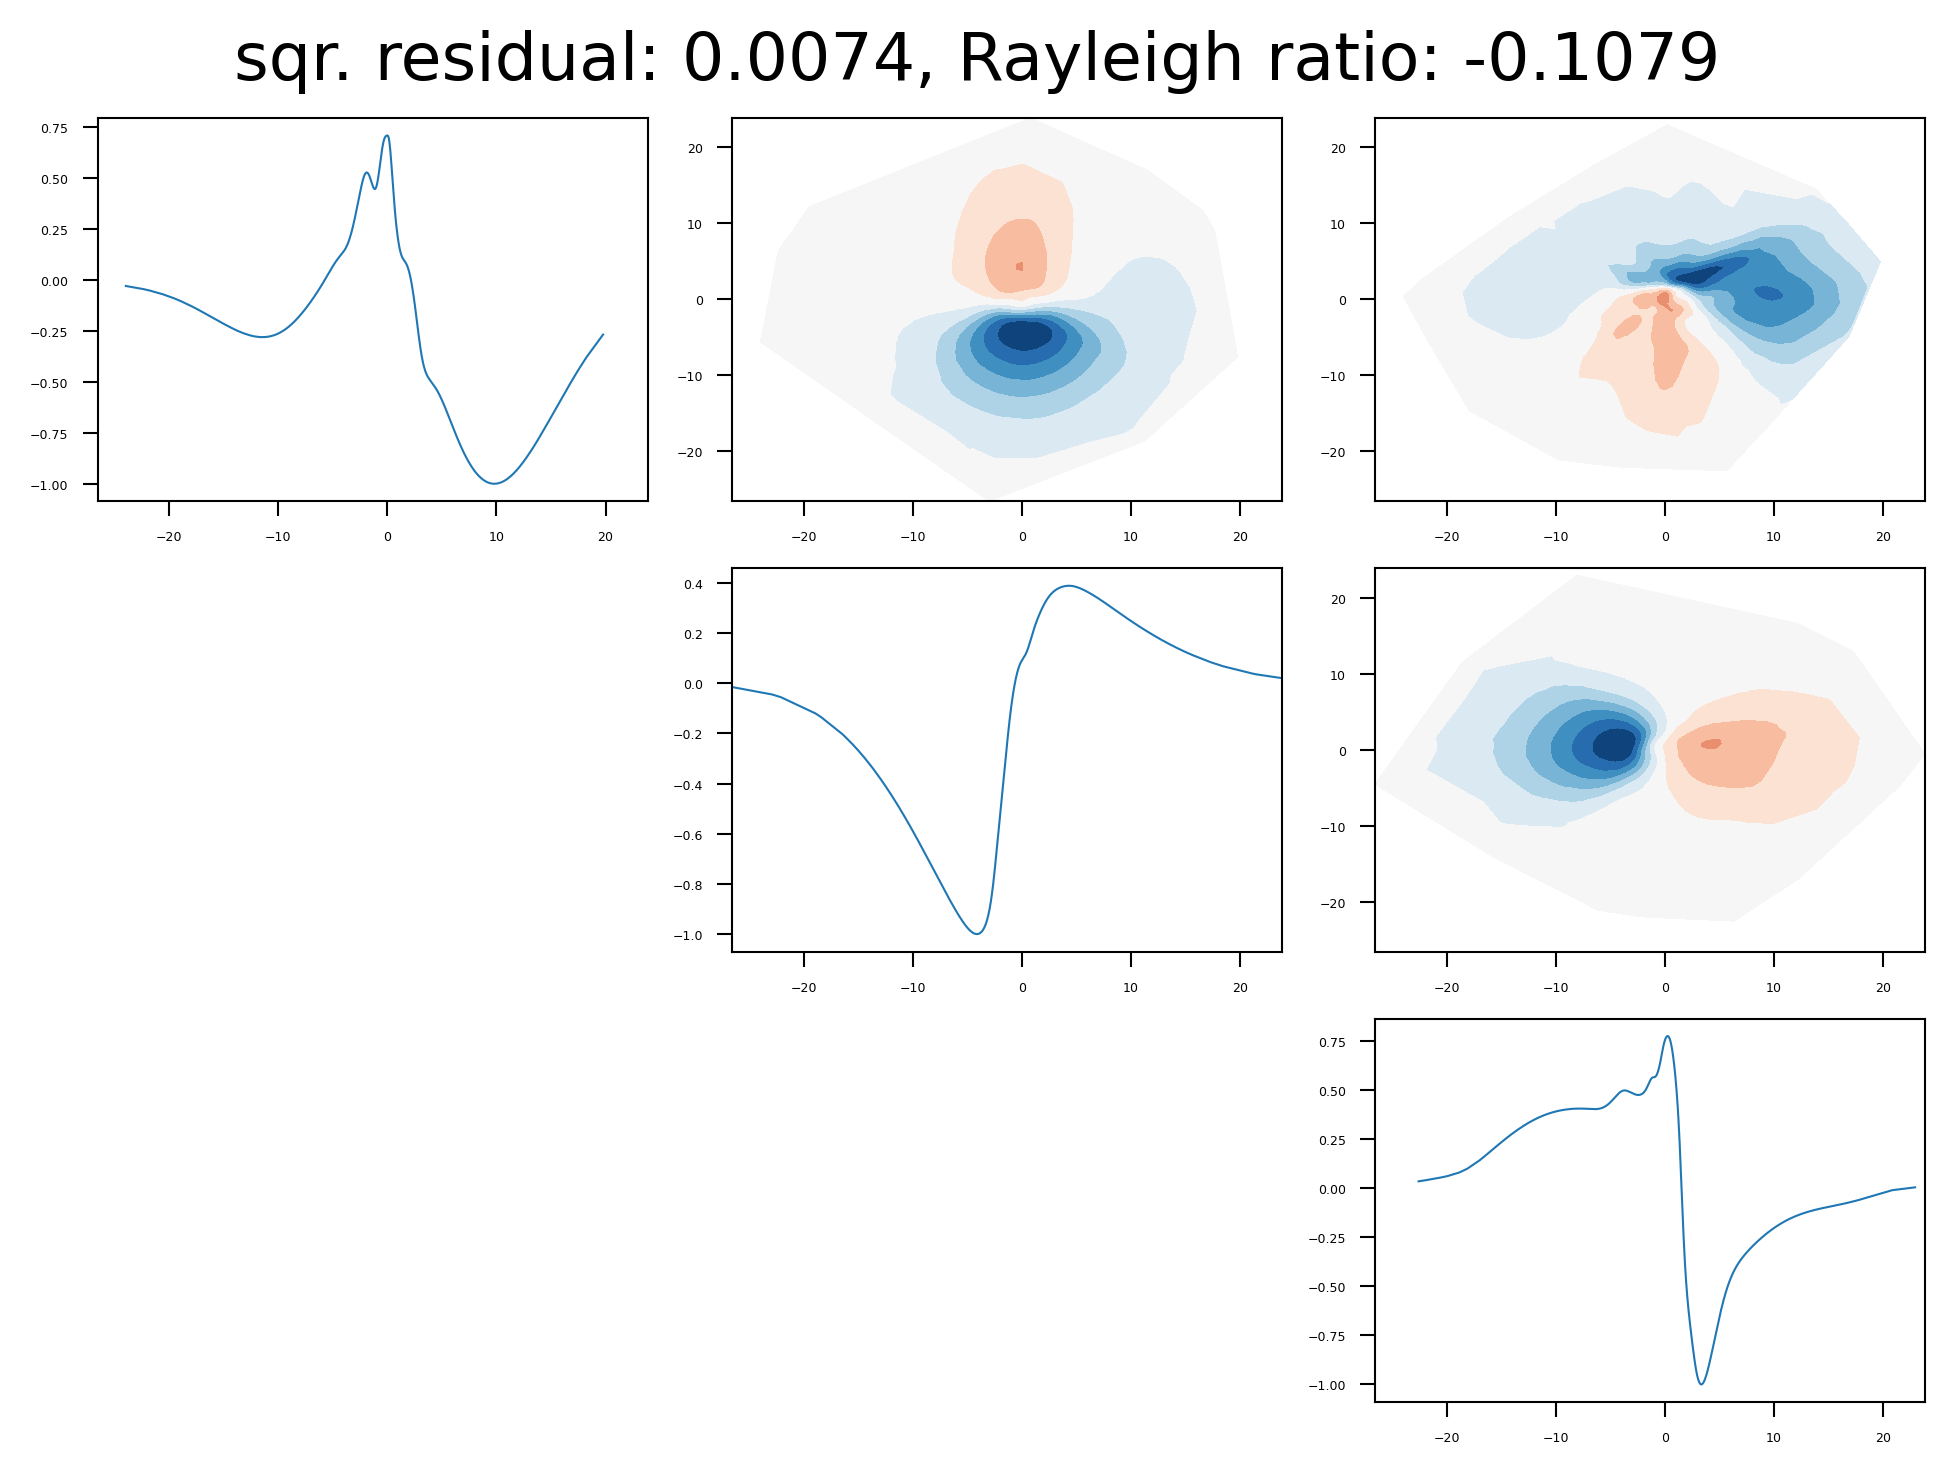

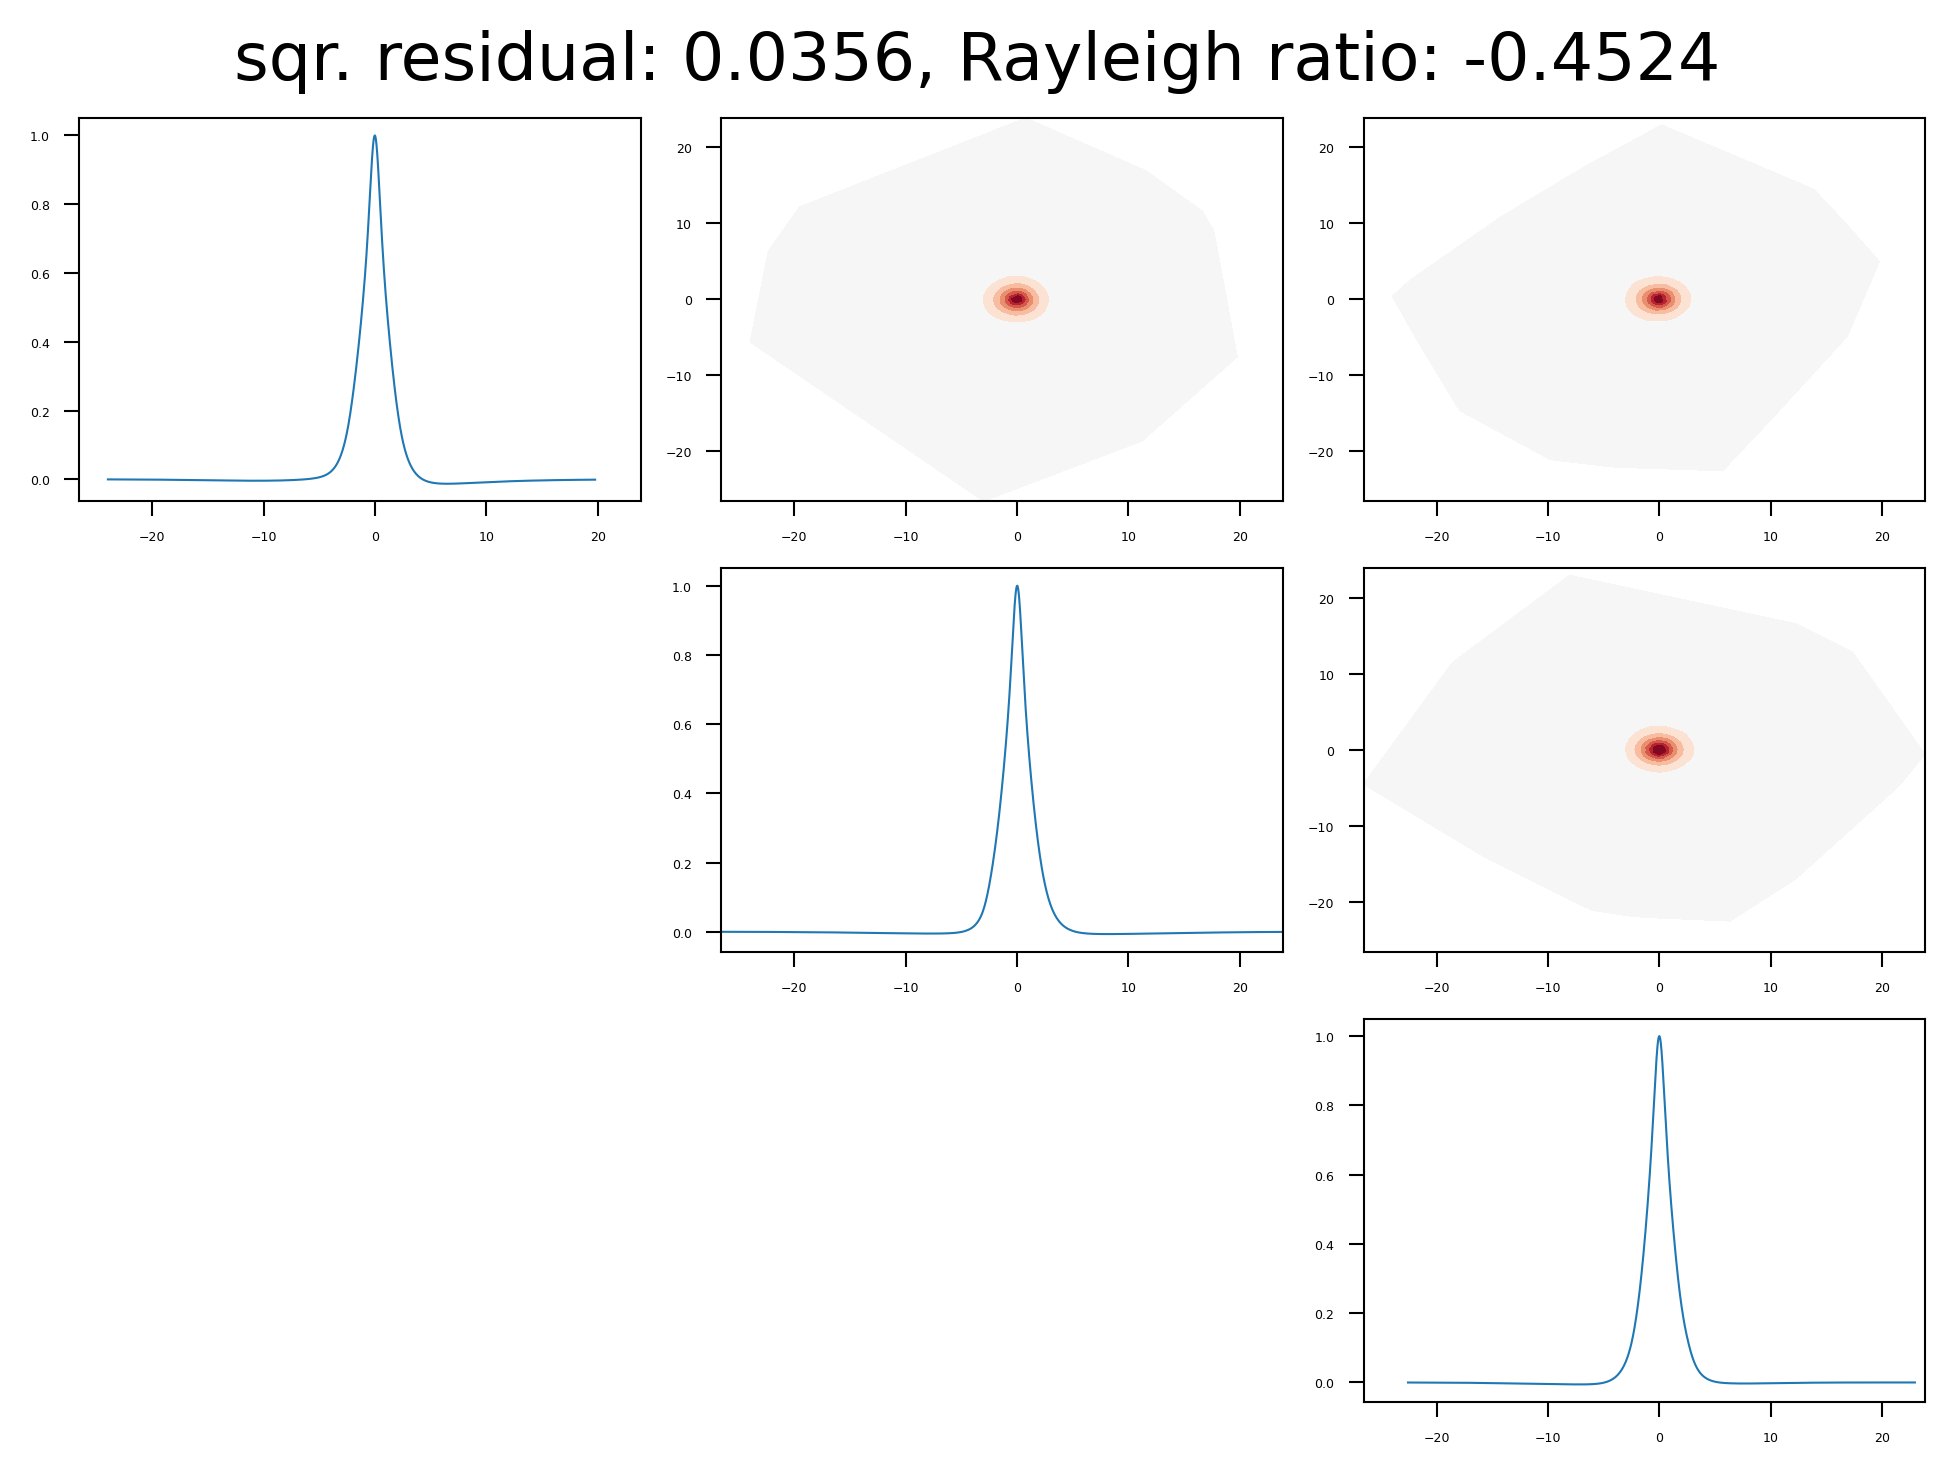

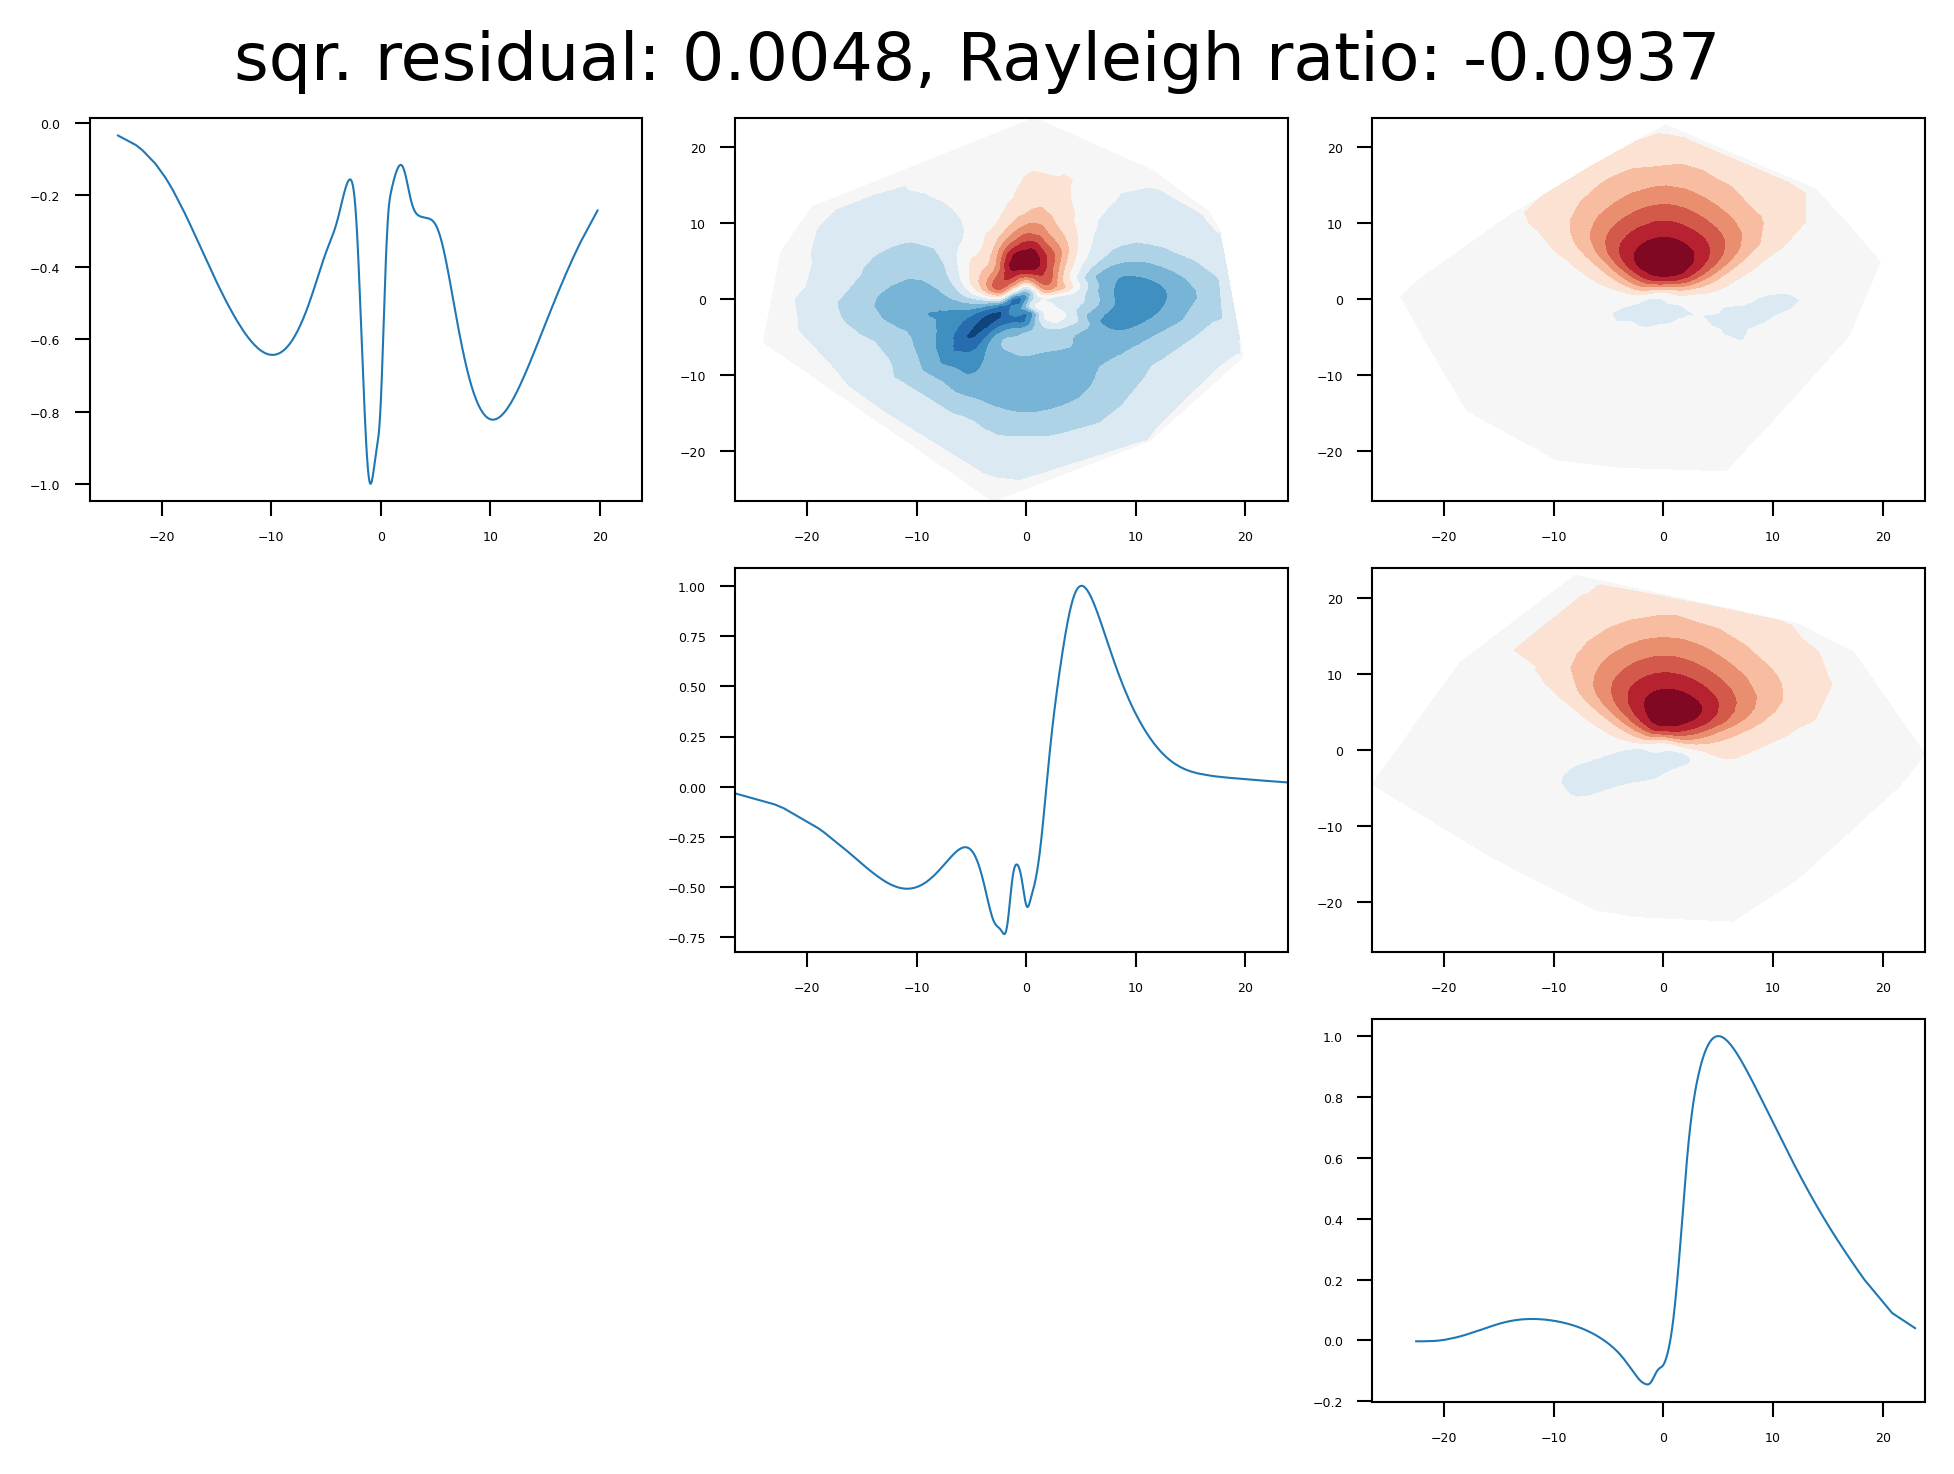

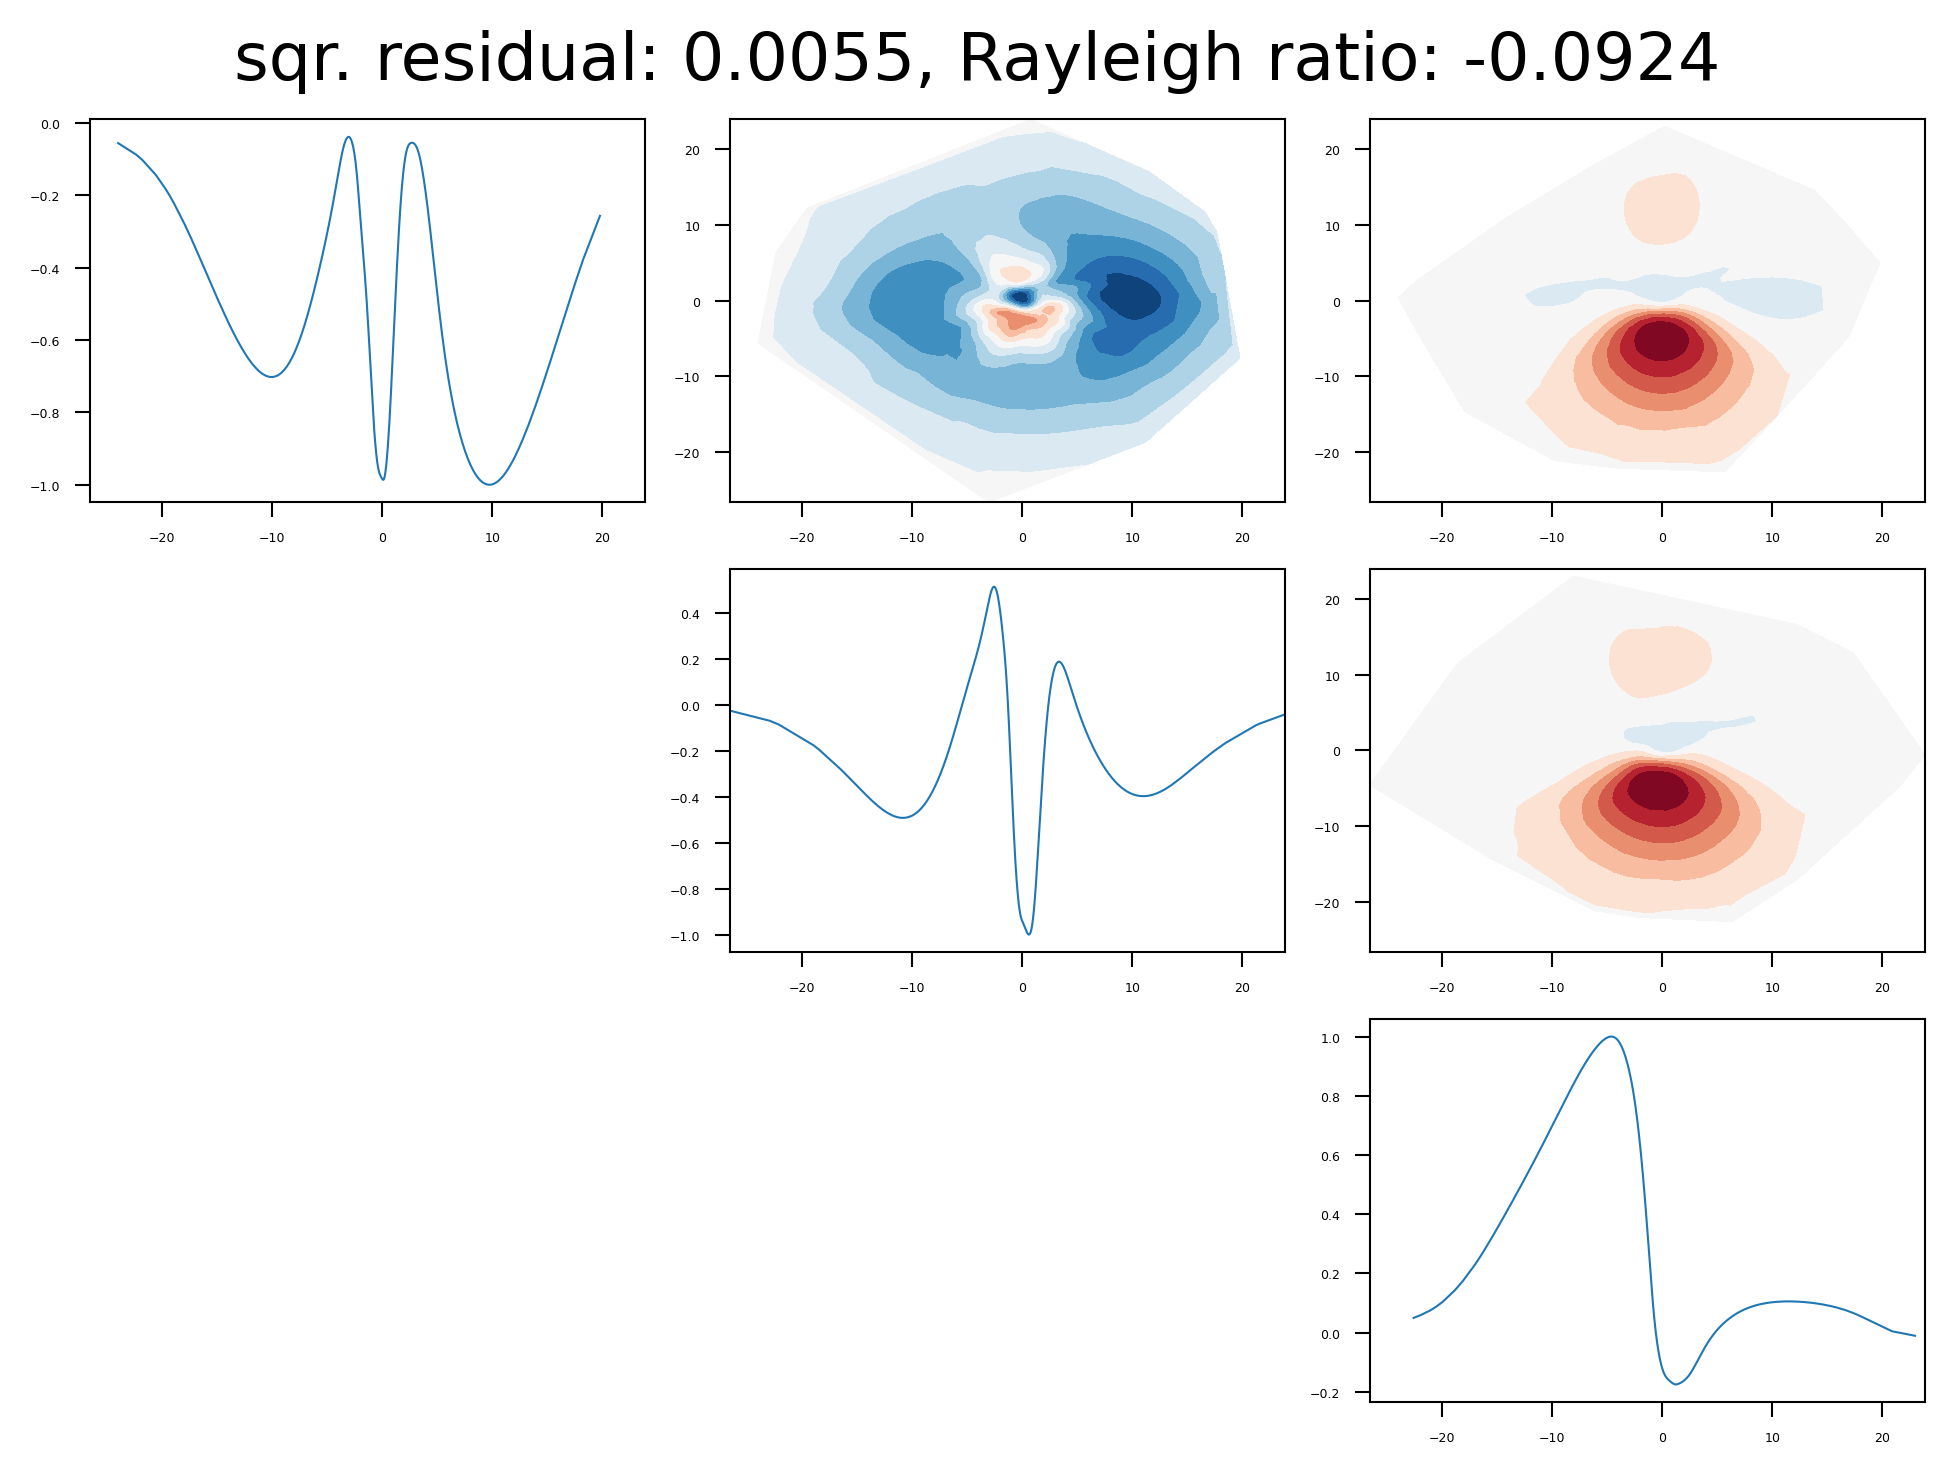

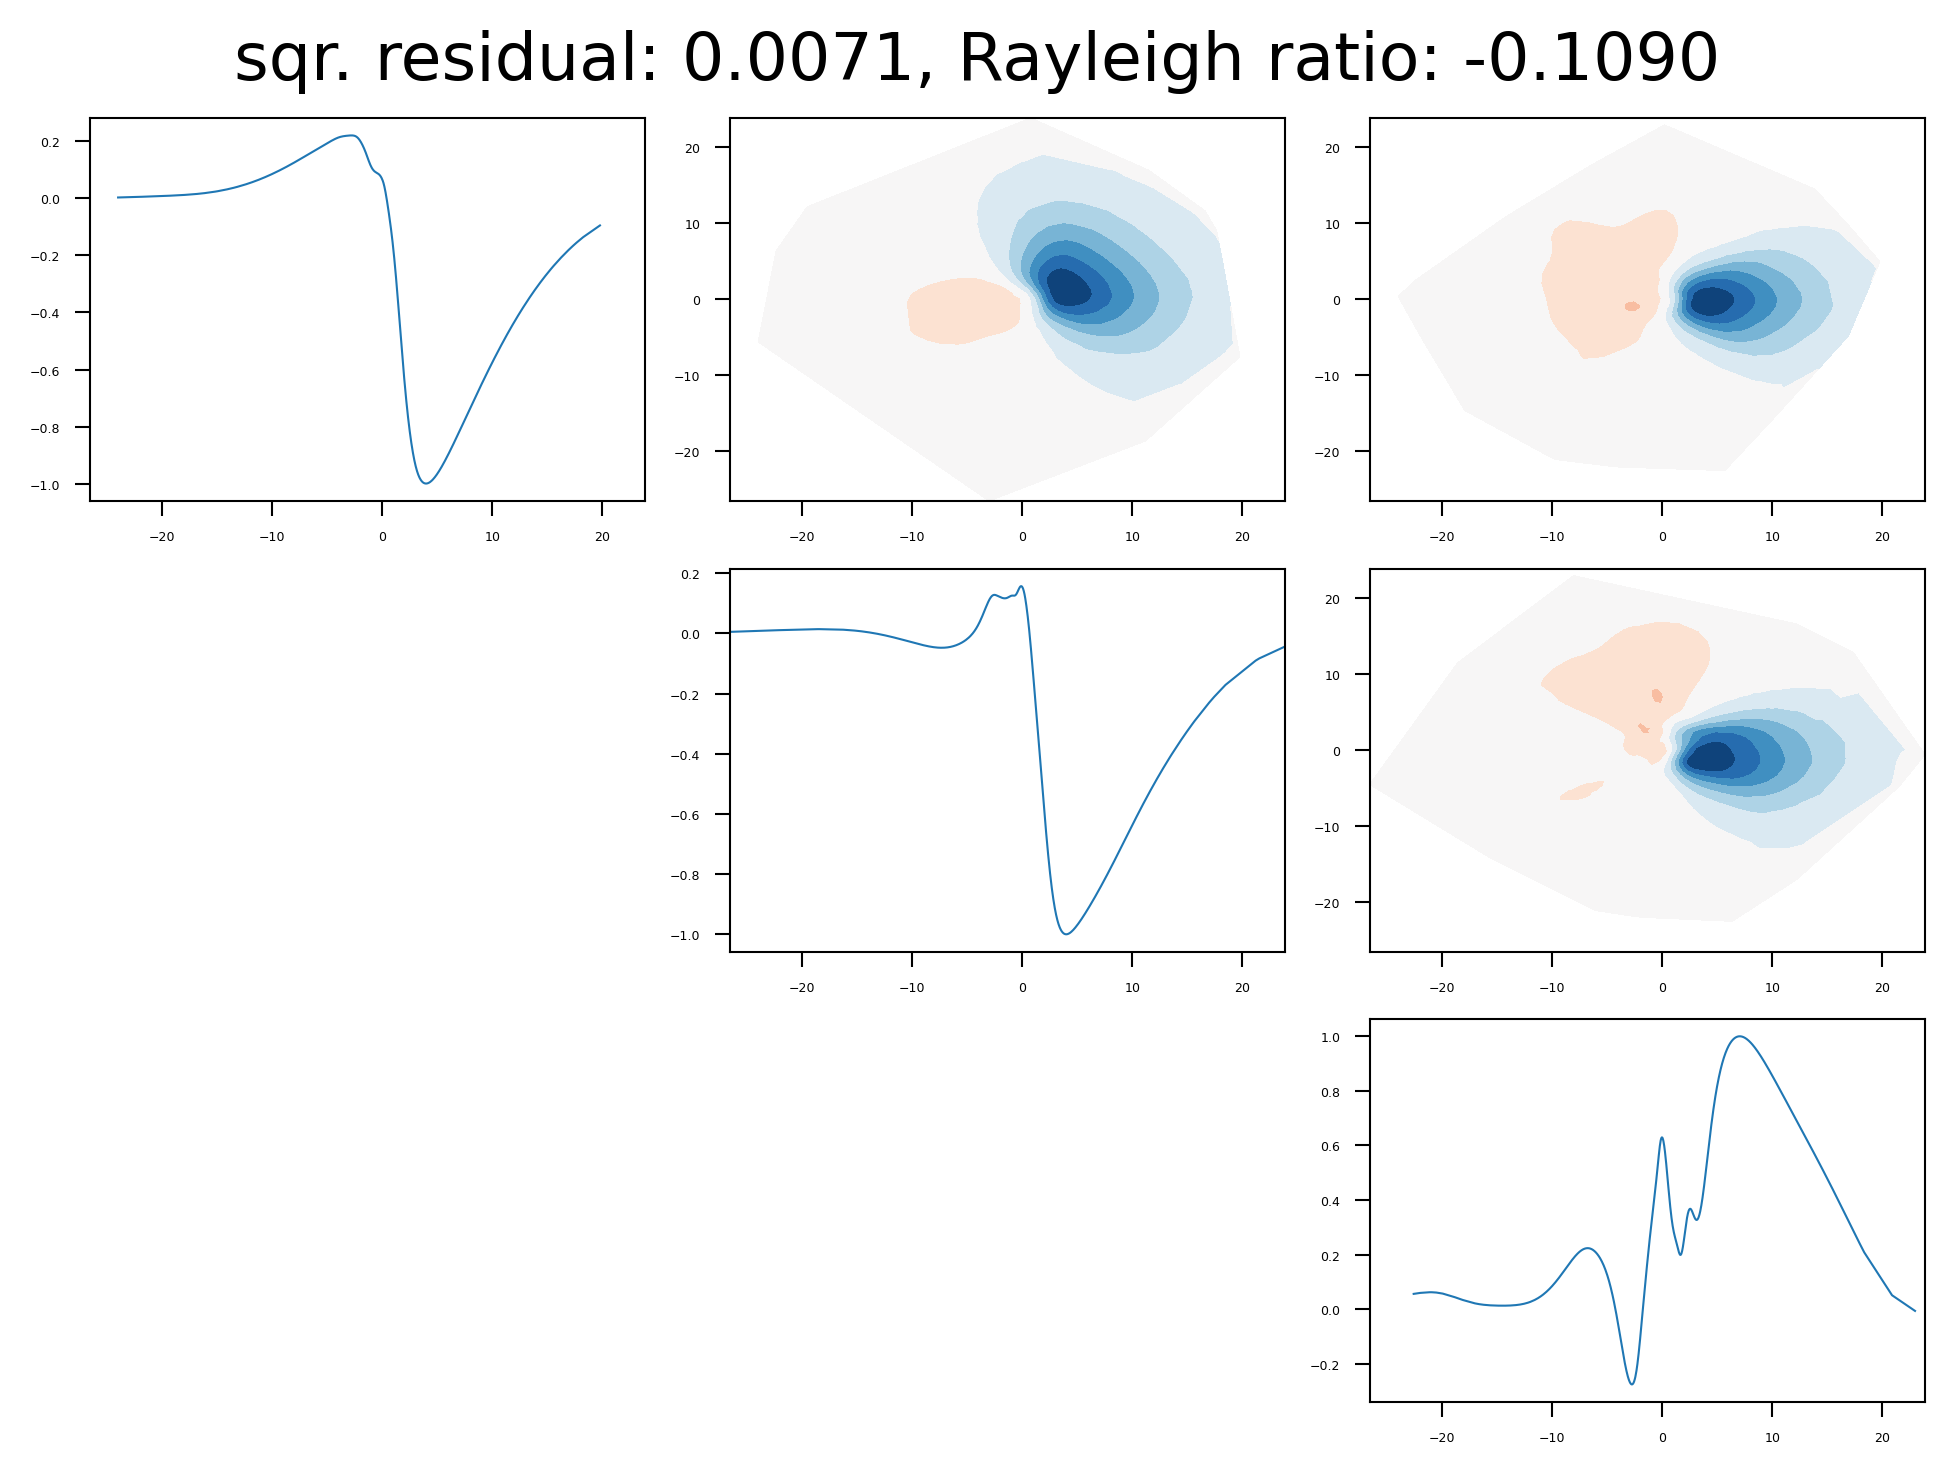

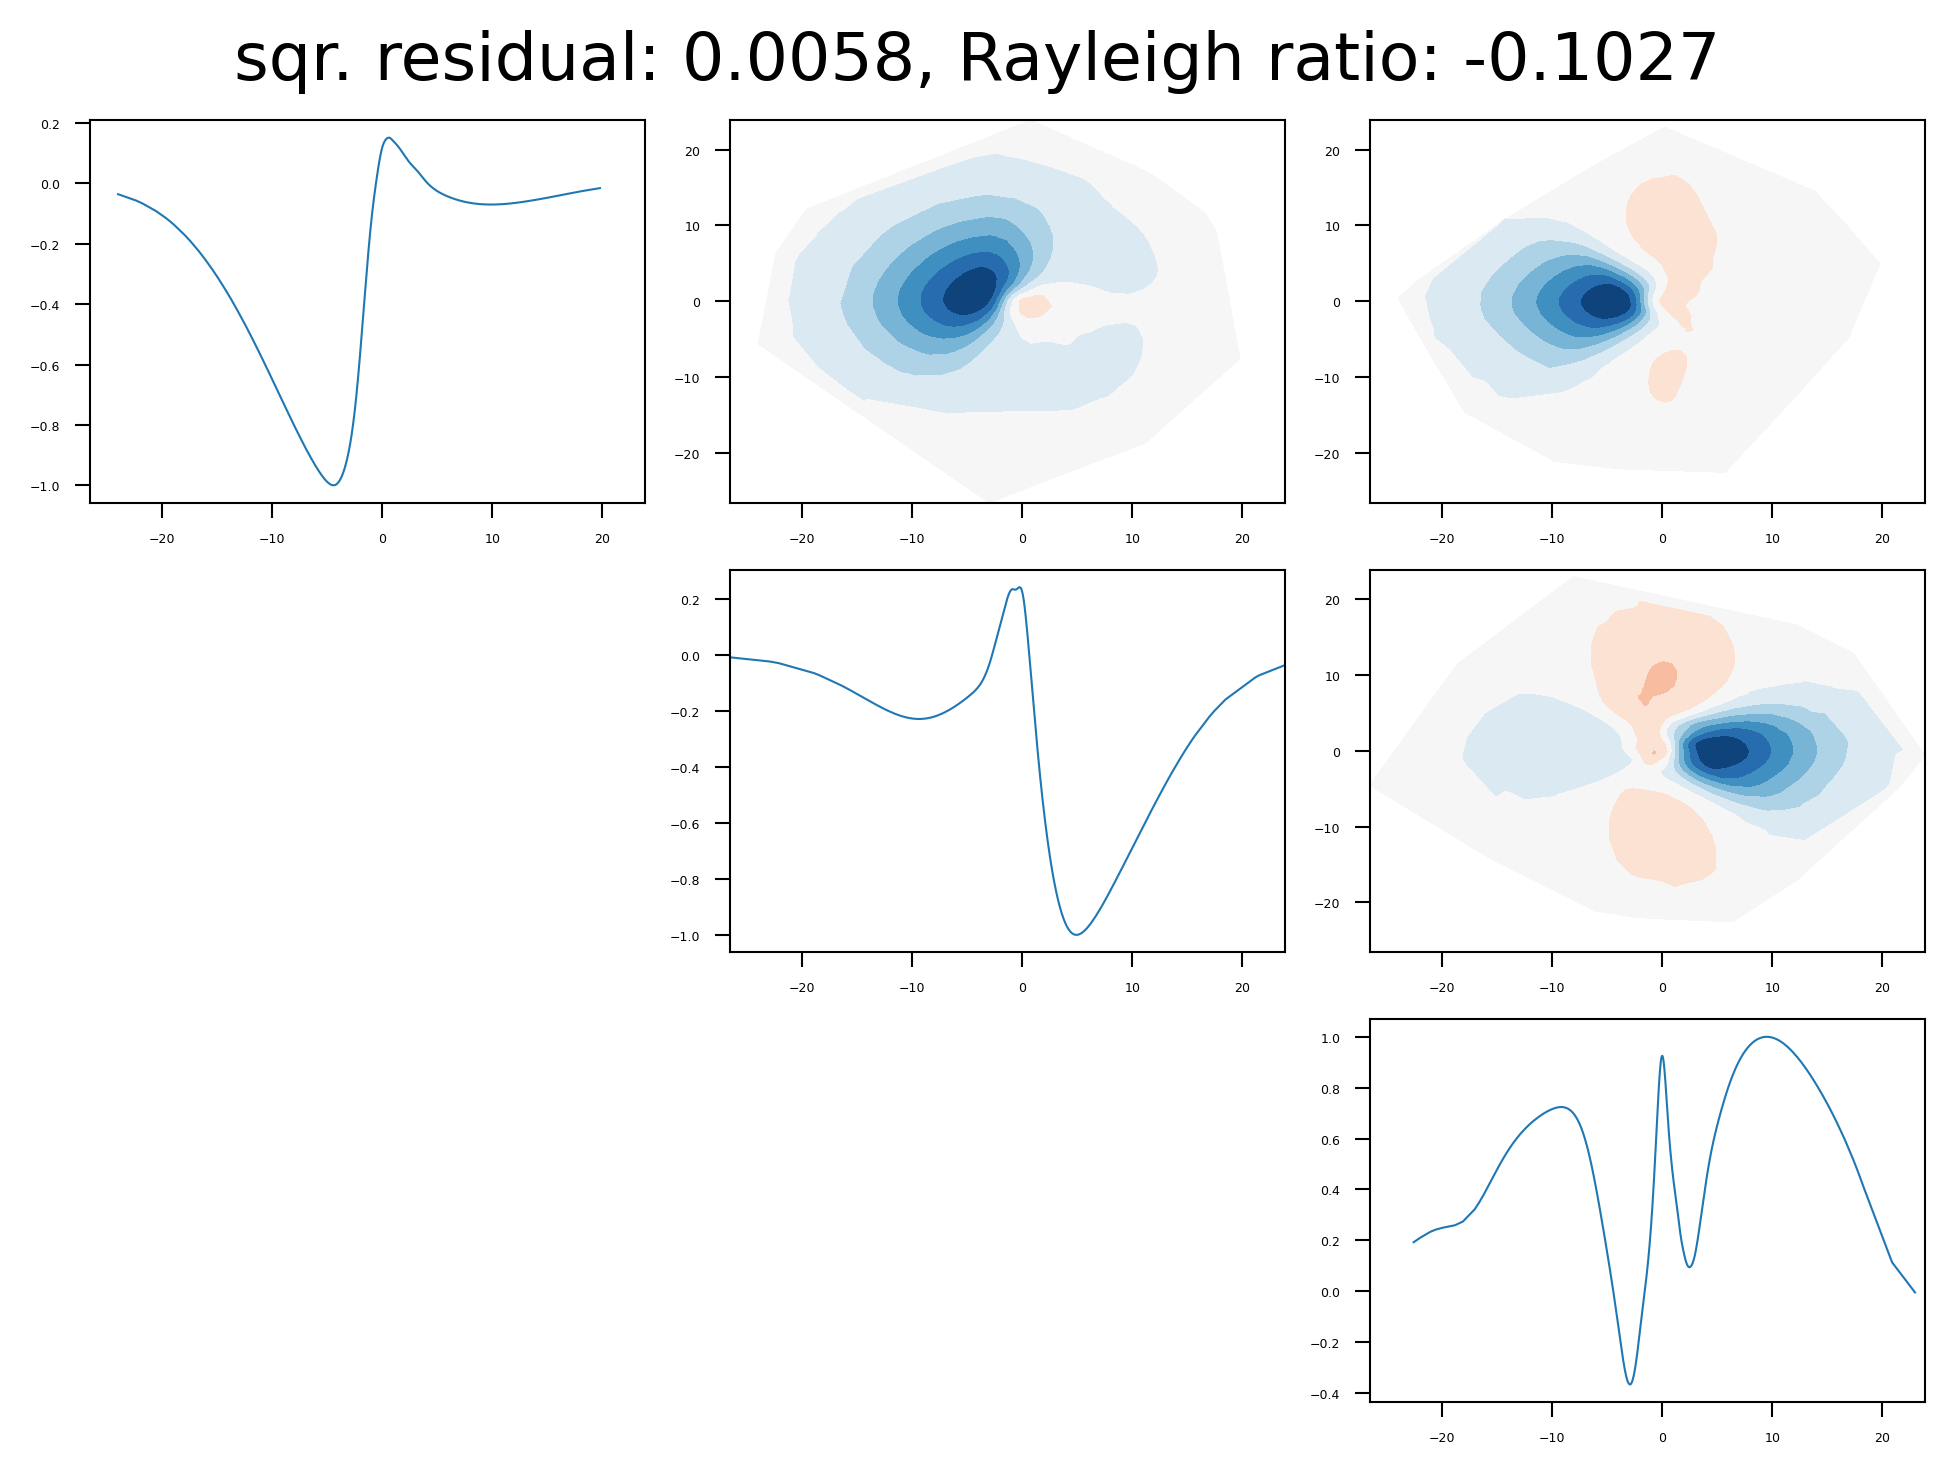

In [15]:
for state in range(num_states):
  # information
  with diff_model_enable(model, x):
    psi = model(x)[state]
    density = torch.ones(S) #model.weigth_function(x)
    sqr_res_for_psi = SqrResidualForPsi(psi, x, model.potential, density)
    Rayleigh_for_psi = Rayleigh(psi, x, potential, density)
  CacheRayleigh.clear()
  CacheHamilt.clear()
  info = f"sqr. residual: {sqr_res_for_psi.item():.4f}, "
  info += f"Rayleigh ratio: {Rayleigh_for_psi.item():.4f}"
  
  dims = list(range(model.dim_coord))
  fig = plt.figure(dpi=300, layout='constrained')

  fig.suptitle(info, fontsize=16)

  xmax = torch.max(x).detach().cpu()
  xmin = torch.min(x).detach().cpu()

  for dim1, dim2 in combinations_with_replacement(dims, 2):
    ax = fig.add_subplot(
      model.dim_coord, model.dim_coord, 1+dim1*model.dim_coord+dim2,
      # aspect='equal'
    )
    ax.tick_params(axis='both', which='major', labelsize=3)
    ax.tick_params(axis='both', which='minor', labelsize=3)
    ax.tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(0.5)
    if dim1 == dim2:
      x1 = torch.sort(x[:,dim1])[0]
      
      xx = torch.zeros_like(x)
      xx[:,dim1] = x1
      
      yy = model(xx)[state]
      yy = yy / torch.max(abs(yy))
      
      ax.plot(
        x1.detach().cpu(),
        yy.detach().cpu(),
        linewidth=0.5
      )
      ax.set_xlim(xmin,xmax)
    else:      
      xx = torch.zeros_like(x)
      xx[:,[dim1,dim2]] = x[:,[dim1,dim2]]
      
      yy = model(xx)[state]
      yy = yy / torch.max(abs(yy))

      ax.tricontourf(
        xx[:,dim1].detach().cpu(),
        xx[:,dim2].detach().cpu(),
        yy.squeeze(1).detach().cpu(), 
        levels=np.linspace(-1,1,14), 
        cmap="RdBu_r"
      )
      ax.set_xlim(xmin,xmax)
      ax.set_ylim(xmin,xmax)

  fig.savefig(f'images/{name}_state{state}.png')

## History

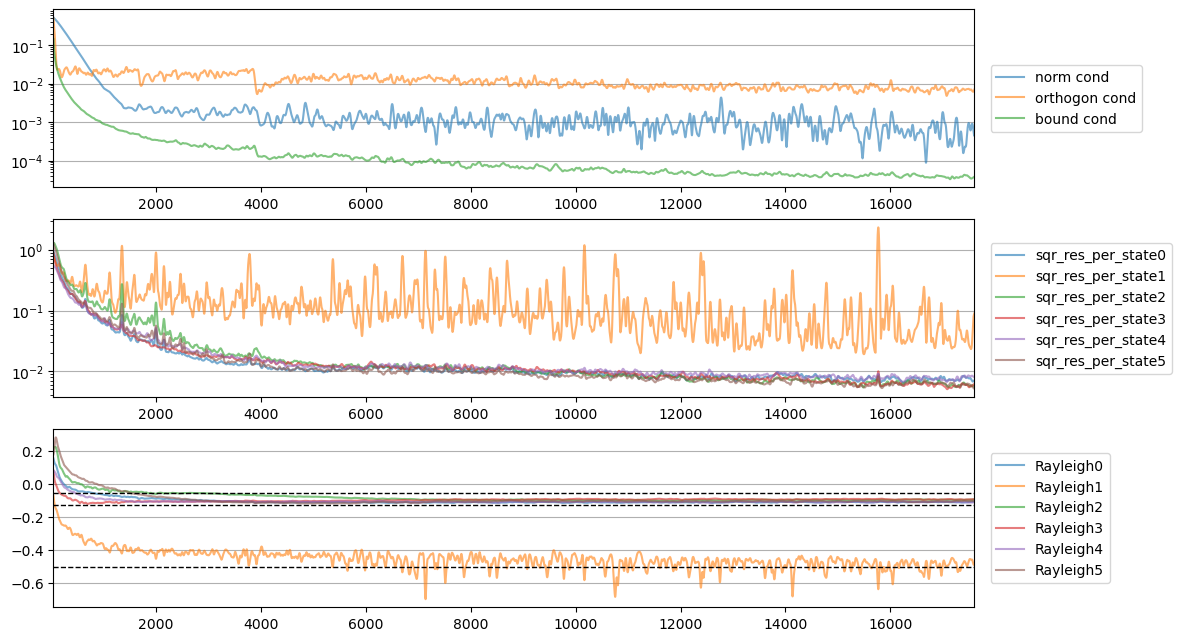

In [17]:
hist = pd.read_csv("history/test_Coulomb-potential_3D_6N_2.csv")

xmax = len(hist)
xmin = 0#16250-1000
N = 6
window = 100
alpha = 0.6

fig, ax = plt.subplots(3,1, layout='constrained',figsize=(11.7,6.3))

hist[['norm cond','orthogon cond','bound cond']][xmin:xmax].rolling(window, center=True, win_type='gaussian').mean(std=0.15*window).plot(xlim=(xmin, xmax), ax = ax[0], alpha=alpha)
hist[[f"sqr_res_per_state{s}" for s in range(N)]][xmin:xmax].rolling(window, center=True, win_type='gaussian').mean(std=0.15*window).plot(xlim=(xmin, xmax), ax = ax[1], alpha=alpha)

hist[[f'Rayleigh{i}' for i in range(N)]][xmin:xmax].rolling(window, center=True, win_type='gaussian').mean(std=0.15*window).plot(xlim=(xmin, xmax), legend=False, ax = ax[2], alpha=alpha)
ax[2].axhline(y=-1/2, color='k', linestyle='--', lw=1)
ax[2].axhline(y=-1/2/2**2, color='k', linestyle='--', lw=1)
ax[2].axhline(y=-1/2/3**2, color='k', linestyle='--', lw=1)

for ax_ in ax:
    ax_.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
    ax_.grid(axis='y')
    ax_.set_xlim(xmin+window/2,xmax-window/2)
    # ax_.axvline(x=3870,c='red',ls='--',lw=1)
    # ax_.axvline(x=3870-2210,c='red',ls='--',lw=1)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

# fig.savefig(f"images/{name}_history.png")